# Soft Exudates Detection

Here we present a step-by-step algorithm based on image processing and machine learning for the detection of soft exudates in fundus images.

This was developed as part of a study project during the MAIA master's program in the image processing module.

##### Imports

In [7]:
# **** Essential libraries ****
# numpy==1.23.5
# opencv-python==4.10.0.84
# pandas==2.2.3
# matplotlib==3.9.2
# scikit-image==0.24.0
# scipy==1.13.1
# glrlm==0.1.0
# tqdm==4.66.5
# scikit-learn==1.5.2

In [8]:
import numpy as np
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt    
import math
import os
import random
import skimage
import scipy
import glrlm
from tqdm import tqdm

# feature extraction and feature engineering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

# machine learning models
from sklearn.svm import SVC

# model evaluation
from sklearn.metrics import accuracy_score, average_precision_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import PrecisionRecallDisplay


##### Global variables and constants

In [9]:
IMG_ORIGINAL_DIMENSIONS = (4288, 2848)
IMG_DIMENSIONS_10 = (428, 284)
MIN_EXUDATE_AREA = 773
MAX_EXUDATE_AREA = 54468

##### Util functions

In [10]:
# -------- loading functions
def load_gt(img_path_name, img_size=None, filter_area=10):
    if os.path.isfile(img_path_name):
        if filter_area is None:
            return cv.imread(img_path_name, cv.IMREAD_UNCHANGED)
        gt = cv.imread(img_path_name, cv.IMREAD_UNCHANGED)
        real_sex, _  = cv.findContours(gt, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
        real = []
        for contour in real_sex:
            if cv.contourArea(contour)>filter_area:
                real.append(contour)

        gt_real = np.zeros((gt.shape[0],gt.shape[1]), np.uint8)
        cv.drawContours(gt_real, real, -1, (255, 255, 255), -1)
        return gt_real
    
    else:
        # print("Image: ", img_path_name, "Not found")
        if img_size is not None:
            return np.zeros((img_size[0], img_size[1]), np.uint8)
        return None

# -------- Visualization functions
def notebook_show(img, description, separator=" ", show=False, explanation_depth=0, step_depth=0):
    if show and explanation_depth >= step_depth:
        str_description = ""

        if type(description) == str:
            str_description = description

        elif type(description) == tuple or type(description) == list :
            for i in range(len(description)):

                dec_piece = description[i]

                if type(description[i]) != str:
                    dec_piece = str(description[i])

                if i < len(description) -1:
                    str_description += dec_piece + separator
                else:
                    str_description += dec_piece

        print(str_description)
        imagen = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        plt.imshow(imagen)
        plt.axis('off')
        plt.show()


def draw_contours(img, contours, thickness=-1, color=(255, 255, 255), contour_id=-1):
    if len(img.shape) < 3:
        img_with_contours = cv.cvtColor(img,cv.COLOR_GRAY2RGB)
    else:
        img_with_contours = img.copy()
    cv.drawContours(img_with_contours, contours, contour_id, color, thickness)
    return img_with_contours

def draw_contours_with_random_colors(contours, img_size):
    img_res = np.zeros((img_size[0], img_size[1], 3), dtype=np.uint8)
    for contour_index in range(len(contours)):
        r = random.randint(0, 255)
        g = random.randint(0, 255)
        b = random.randint(0, 255)
        cv.drawContours(img_res, contours, contour_index, (b,g,r), -1)
    return img_res

def draw_mask(img, mask, thickness=-1, mask_color=(0,255,0)):
    if mask is not None:
        contours,_ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        return draw_contours(img, contours, thickness=thickness, color=mask_color, contour_id=-1)
    return img

def create_contours_mask(contours, img_dimensions, id=-1):
    mask = np.zeros((img_dimensions[0],img_dimensions[1]), np.uint8)
    cv.drawContours(mask, contours,  id, (255,255,255), -1)
    return mask

def draw_rois(img, rois, thickness=-1, color=(0, 0, 255)):
    if len(img.shape) < 3:
        img2 = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    else:
        img2 = img.copy()

    for roi in rois:
        cv.rectangle(img2,
                     (roi[0], roi[1]),
                     (roi[2], roi[3]),
                     color, thickness)
    return img2


def get_contours_rois(contours, padding_th=None, img_shape=None):
    rois = []
    if padding_th is not None and img_shape is not None:
        for i in range(len(contours)):
            x, y, w, h = cv.boundingRect(contours[i])

            pad_x = 0
            pad_y = 0
            area = cv.contourArea(contours[i])

            for th, multiplier in padding_th:
                if area < th:
                    pad_x = w * multiplier
                    pad_y = h * multiplier
                    break
            rois.append((max(0, int(x-pad_x)), max(0, int(y-pad_y)), min(img_shape[1], int(x+w+pad_x)), min(img_shape[0], int(y+h+pad_y))))
    else:
        for i in range(len(contours)):
            x, y, w, h = cv.boundingRect(contours[i])
            rois.append((x, y, x+w, y+h))
    return rois


def filter_contour_area(contours, min_area, max_area=-1):
    candidates_filtered = []

    if max_area == -1:
        for contour in contours:
            area = cv.contourArea(contour)
            if area > min_area:
                candidates_filtered.append(contour) 
    else:
        for contour in contours:
            area = cv.contourArea(contour)
            if area > min_area and area < max_area:
                candidates_filtered.append(contour) 

    return candidates_filtered

def get_roi(img, roi):
    return img[roi[1]:roi[3], roi[0]:roi[2]]


def plot_points_2D(X, labels):
    """
    Plots points in 2D with colors according to their class.
    
    Parameters:
    X: np.array of shape (n_samples, 2) with the coordinates of the points.
    y: list or np.array of size (n_samples) with the classes (0 or 1) of each point.
    """
    # Convert lists to NumPy arrays for better data handling
    X = np.array(X)
    labels = np.array(labels)
    
    # Create masks for class 0 and class 1
    mask_0 = (labels == 0)
    mask_1 = (labels == 1)

    # Plot the points
    plt.scatter(X[mask_0, 0], X[mask_0, 1], color='blue', label='No SE')
    plt.scatter(X[mask_1, 0], X[mask_1, 1], color='red', label='SE')

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# -------- image redimentioning functions
def get_resize_dimensions(img, scale_percent=1):
    width = int(img.shape[1] * scale_percent)
    height = int(img.shape[0] * scale_percent)
    return (width, height)

def resize(img, scale):
    return cv.resize(img, get_resize_dimensions(img, scale))

def get_image_10_percent(img):
    sf =  round(IMG_DIMENSIONS_10[0]/img.shape[1], 2)
    # sf =  0.1
    return (resize(img, sf), sf)

def resize_contours(contours, sf):
    for i in range(len(contours)):
        for j in range(len(contours[i])):
            contours[i][j][0][0] = sf * contours[i][j][0][0]
            contours[i][j][0][1] = sf * contours[i][j][0][1]

def resize_rectangle(rect, sf):
    return (int(rect[0]*sf), int(rect[1]*sf), int(rect[2]*sf), int(rect[3]*sf))

def resize_rectangles(rects, sf):
    rects_resized = []
    for rect in rects:
        rects_resized.append(resize_rectangle(rect, sf))
    return rects_resized

# -------- geometric functions
def resize_circle(circle, sf, translate=False):
    if translate:
        return ((int(circle[0][0]*sf), int(circle[0][1]*sf)),  int(circle[1]*sf))
    else:
        return ((circle[0][0], circle[0][1]),  int(circle[1]*sf))
    

# -------- masks functions
def apply_mask(img, mask, mask_value=0):
    img_masked = img.copy()
    if mask_value == -1:
        img_masked[mask==0] = 0
    else:
        img_masked[mask==255] = mask_value
    return img_masked


def create_circle_mask(circle, img_dimensions):
    mask = np.zeros((img_dimensions[0],img_dimensions[1]), np.uint8)
    cv.circle(mask, circle[0], circle[1], (255,255,255), -1)
    return mask


def add_patch(img, patch, pos, circular=False):
    if circular:
        pos = [pos[0][0]-pos[1], pos[0][1]-pos[1], 2*pos[1], 2*pos[1]]
    img_restored = img.copy()
    img_restored[pos[1]:pos[1]+pos[3], pos[0]:pos[0]+pos[2]] = patch
    return img_restored   


# -------- histogram eq functions
def gamma_correction(src, gamma):
    invGamma = 1 / gamma

    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)

    return cv.LUT(src, table)


# -------- Binary morphology
def break_big_elements(img, size_th=400, se=5):
    candidates, _ = cv.findContours(img, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
    small_elements = []

    for i in range(len(candidates)):
        area = cv.contourArea(candidates[i])
        if area < size_th:
            small_elements.append(candidates[i])

    SE = cv.getStructuringElement(cv.MORPH_ELLIPSE, (se,se))
    img_open = cv.morphologyEx(img, cv.MORPH_OPEN, SE)

    cv.drawContours(img_open, small_elements, -1, (255, 255, 255), -1)
    return img_open


# -------- metrics
def label_contours(candidates_contours, gt_contours, img_shape, overlap_threshold=0.5):
    gt_len = len(gt_contours)
    candidates_len = len(candidates_contours)

    if gt_len == 0:
        return np.zeros(candidates_len), 0

    candidates_match = np.full((gt_len, 2), -1)
    candidates_labels = np.zeros(candidates_len)
    TP = 0

    for i in tqdm(range(candidates_len)):
        mask_one = np.zeros((img_shape[0],img_shape[1]), np.uint8)
        cv.drawContours(mask_one, candidates_contours, i, (255, 255, 255), -1)

        for j in range(gt_len):
            gt_one = np.zeros((img_shape[0],img_shape[1]), np.uint8)
            cv.drawContours(gt_one, gt_contours, j, (255, 255, 255), -1)  

            intersection = cv.bitwise_and(mask_one, gt_one)
            area_intersection = cv.countNonZero(intersection)
            union = cv.bitwise_or(mask_one, gt_one)
            area_union = cv.countNonZero(union)

            if area_intersection > 0: 
                overlap = area_intersection / area_union
                if overlap > overlap_threshold:
                    if candidates_match[j, 0] != -1:
                        if overlap>candidates_match[j, 1]:
                            candidates_labels[candidates_match[j, 0]] = 0
                            candidates_labels[i] = 1
                            candidates_match[j, 0] = i
                            candidates_match[j, 1] = overlap
                            break

                    else:
                        candidates_match[j, 0] = i
                        candidates_match[j, 1] = overlap
                        candidates_labels[i] = 1
                        TP += 1
                        break

    FN = len(gt_contours) - TP

    if (TP + FN)   == 0:
        img_sensitivity = 0
    else:
        img_sensitivity = TP / (TP + FN)  

    return candidates_labels, img_sensitivity

## Load reference image

In [11]:
img_path_name = 'data/images/training/IDRiD_13.jpg'
img_gt_od_path_name = 'data/groundtruths/groundtruths_OD/training/IDRiD_13_OD.tif'
img_gt_se_path_name = 'data/groundtruths/groundtruths_SE/training/IDRiD_13_SE.tif'

img = cv.imread(img_path_name, cv.IMREAD_UNCHANGED)
img_gt_od = cv.imread(img_gt_od_path_name, cv.IMREAD_UNCHANGED)
img_gt_se = load_gt(img_gt_se_path_name)


Img:  data/images/training/IDRiD_13.jpg


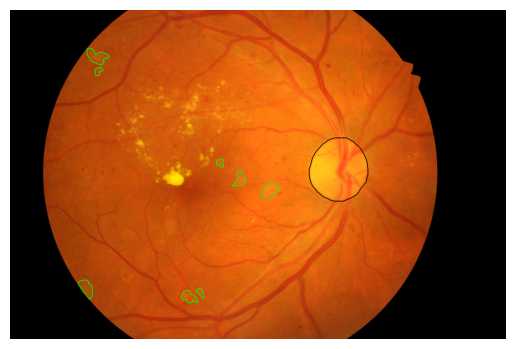

In [12]:
img_show = img.copy()
img_show = draw_mask(img_show, img_gt_od, mask_color=(0,0,0), thickness=5)
img_show = draw_mask(img_show, img_gt_se, mask_color=(0,255,0), thickness=5)
notebook_show(img_show, ("Img: ", img_path_name), show=True, explanation_depth=1, step_depth=0)


## Optical Disk removal

### Basic OD removal

In [124]:
class BasicODRemoval:
    CLAHE_TH_LOW= 116 
    CLAHE_TH_HIGH= 135 

    TH=205
    SE_SIZE=10
    HOUGH_DP=4
    HOUGH_MINRADIUS=15
    HOUGH_MAXRADIUS=40
    CLAHE_CLIP_LOW=1
    CLAHE_CLIP_HIGH=6

    def __init__(self, notebook=False, explanation_depth=0):
        self.notebook = notebook
        self.explanation_depth = explanation_depth


    def remove_od(self, img, circle_sf=1):
        # obtain od mask
        od_mask = self.get_od_mask(img, circle_sf)

        # apply mask
        img_no_od = apply_mask(img, od_mask)
        return img_no_od
    

    def get_od_roi(self, img):
        # resize image to the 10% of the full scale fundus image (4288, 2848)
        img_resized, sf = get_image_10_percent(img)

        # obtain od circle of the 10% image
        roi_od_circle = self.__get_OD_circle(img_resized)

        # convert obtained od circle into roi
        if roi_od_circle[1] < self.HOUGH_MINRADIUS * 1.5:
            roi_od_circle = resize_circle(roi_od_circle, 2, translate=False) 
        elif roi_od_circle[1] > self.HOUGH_MAXRADIUS * 0.8:
            roi_od_circle = resize_circle(roi_od_circle, 1.2, translate=False) 
        else:
            roi_od_circle = resize_circle(roi_od_circle, 1.5, translate=False) 

        # scale roi for the img size 
        roi_od_circle_reziced = resize_circle(roi_od_circle, 1/sf, translate=True)

        return roi_od_circle_reziced
    

    def get_od_mask(self, img, circle_sf=1):
        
        # resize image to the 10% of the full scale fundus image (4288, 2848)
        img_resized, sf = get_image_10_percent(img)

        # obtain od circle of the 10% image
        od_circle = self.__get_OD_circle(img_resized)
        
        if self.notebook and self.explanation_depth > 1:
            img_notebook = img_resized.copy()
            cv.circle(img_notebook, od_circle[0], od_circle[1], (255, 255, 255), 2)
            notebook_show(img_notebook, "Step 5: Choosen OD circle", show=self.notebook, explanation_depth=self.explanation_depth, step_depth=1)


        # scale od circle for the img size
        od_circle_reziced = resize_circle(od_circle, 1/sf, translate=True)

        # resize circle if necessary (used in basic soft exudates detection)
        od_circle_reziced = resize_circle(od_circle_reziced, circle_sf, translate=False)

        # obtain od mask
        od_mask = create_circle_mask(od_circle_reziced, (img.shape[0], img.shape[1]))
        return od_mask
    


    def __get_OD_circle(self, img_resized):
        # --------- preprocessing
        img_chanel_v = cv.extractChannel(cv.cvtColor(img_resized, cv.COLOR_RGB2HSV), 2)
        notebook_show(img_chanel_v, "Step 1: The space color of the image is changed to HSV and the Value chanel (V) is extracted", show=self.notebook, explanation_depth=self.explanation_depth, step_depth=1)

        mean_intensity = cv.mean(img_chanel_v)

        # histogram equalization
        clahe_clip = 4
        only_hough = False
        if int(mean_intensity[0]) < self.CLAHE_TH_LOW:
            clahe_clip = self.CLAHE_CLIP_LOW
        elif int(mean_intensity[0]) > self.CLAHE_TH_HIGH:
            clahe_clip = self.CLAHE_CLIP_HIGH
            only_hough = True
        

        # histogram equalization
        clahe = cv.createCLAHE(clipLimit=clahe_clip)
        img_pre_clahe = clahe.apply(img_chanel_v)
        notebook_show(img_pre_clahe, ("Step 2: CLAHE with clip =", clahe_clip), show=self.notebook, explanation_depth=self.explanation_depth, step_depth=1)

        # binarization
        _,img_th = cv.threshold(img_pre_clahe, self.TH, 255, cv.THRESH_BINARY)
        notebook_show(img_th, ("Step 3: Binary threshold with th =", self.TH), show=self.notebook, explanation_depth=self.explanation_depth, step_depth=2)

        # removing small white noise
        SE = cv.getStructuringElement(cv.MORPH_ELLIPSE, (self.SE_SIZE, self.SE_SIZE))
        img_th = cv.morphologyEx(img_th, cv.MORPH_OPEN, SE)
        notebook_show(img_th, ("Step 4: Binary open with elliptical SE size =", self.SE_SIZE, "x", self.SE_SIZE), show=self.notebook, explanation_depth=self.explanation_depth, step_depth=1)

        # obtaining OD candidates
        contour_candidate = self.__disk_segmentation_candidate_contours(img_th)
        hough_candidate = self.__disk_segmentation_candidate_hough(img_th)

        # creating OD mask
        if contour_candidate is None or hough_candidate is None:
            print("ERROR CREATING OD MASK FOR IMG ")
            return None
        else:
            if self.notebook and self.explanation_depth >= 1:
                img_notebook = cv.cvtColor(img_th, cv.COLOR_GRAY2RGB)
                cv.circle(img_notebook, contour_candidate[0], contour_candidate[1], (255, 255,0), 2)
                cv.circle(img_notebook, hough_candidate[0], hough_candidate[1], (0, 255, 255), 2)
                notebook_show(img_notebook, "OD candidates, hough candidate = Yellow; contour candidate = Cyan", show=self.notebook, explanation_depth=self.explanation_depth, step_depth=1)

            candidates_distance = (contour_candidate[0][0] - hough_candidate[0][0])**2 + (contour_candidate[0][1] - hough_candidate[0][1])**2
            if only_hough or candidates_distance > hough_candidate[1]**2:
                return hough_candidate
            else:
                mean_center = ( int((contour_candidate[0][0] + hough_candidate[0][0])/2), int((contour_candidate[0][1] + hough_candidate[0][1])/2))
                mean_radius = int((contour_candidate[1] + hough_candidate[1]) / 2)
                return (mean_center, mean_radius)


    def __disk_segmentation_candidate_contours(self, img):
        # find contours
        candidates, _ = cv.findContours(img, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
        if len(candidates) == 0:
            return None
        
        candidate_features = []

        # filter elements by area
        candidate_counter = 0
        for contour in candidates:
            area = cv.contourArea(contour)
            p = cv.arcLength(contour, True)
            C = 4 * math.pi * area / (p*p)
        
            candidate_features.append((candidate_counter, area, C, p))
            candidate_counter +=1

        # obtaining best OD candidate
        candidate_features.sort(key=lambda x: x[1])
        best_candidate = candidate_features[-1]

        (x,y), radius = cv.minEnclosingCircle(candidates[best_candidate[0]])
        circle = ((int(x),int(y)), int(radius))
        return circle


    def __disk_segmentation_candidate_hough(self, img):
        circles = cv.HoughCircles(img, cv.HOUGH_GRADIENT, dp=self.HOUGH_DP, minDist=10000, param1=255, param2=30,
                                minRadius=self.HOUGH_MINRADIUS, maxRadius=self.HOUGH_MAXRADIUS)
        
        if circles is not None:
            circles = np.uint16(np.around(circles))
            return ((circles[0][0][0], circles[0][0][1]), circles[0][0][2])
        else:
            print("PROBLEM WITH THE IMAGE")
            return None


#### Example

Step 1: The space color of the image is changed to HSV and the Value chanel (V) is extracted


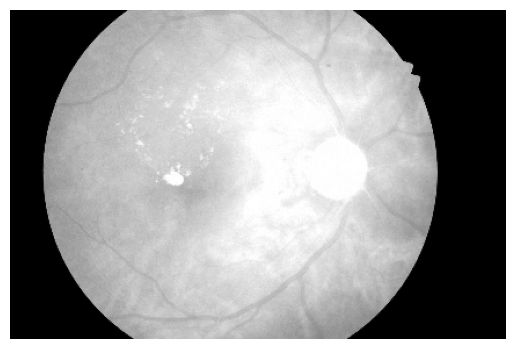

Step 2: CLAHE with clip = 6


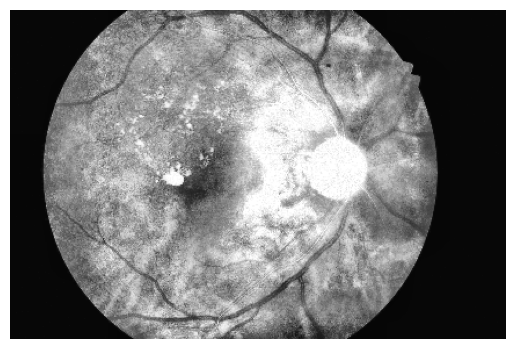

Step 3: Binary threshold with th = 205


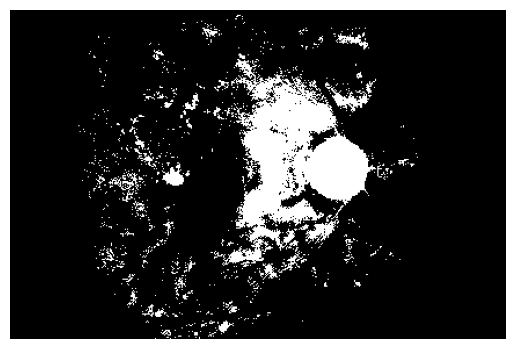

Step 4: Binary open with elliptical SE size = 10 x 10


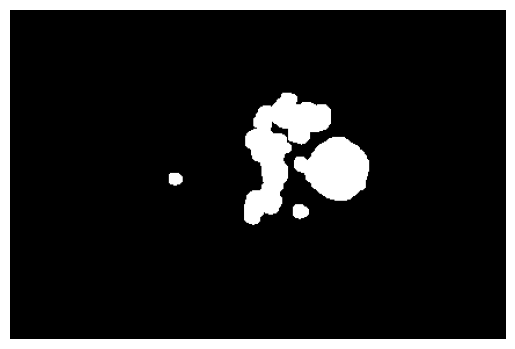

OD candidates, hough candidate = Yellow; contour candidate = Cyan


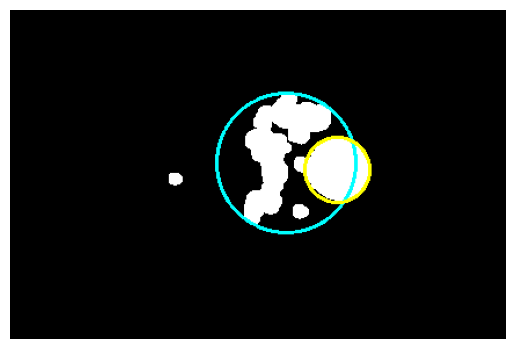

Step 5: Choosen OD circle


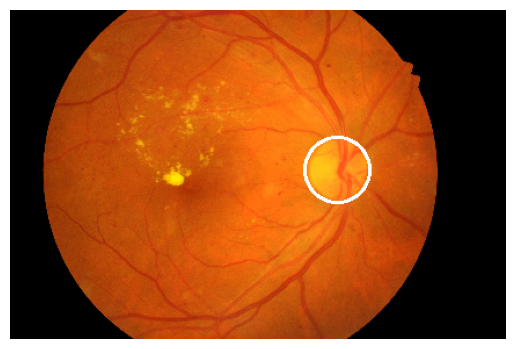

Removed OD and GT OD in green


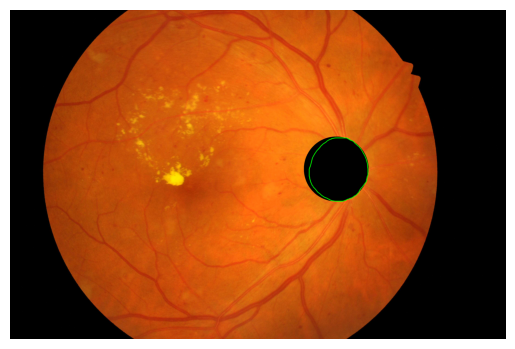

In [125]:
img_no_od_basic = BasicODRemoval(notebook=True, explanation_depth=5).remove_od(img)

img_no_od_basic_show = draw_mask(img_no_od_basic.copy(), img_gt_od, mask_color=(0,255,0), thickness=5)
notebook_show(img_no_od_basic_show, ("Removed OD and GT OD in green"), show=True, explanation_depth=1, step_depth=0)

### Advanced OD removal

In [126]:

class AdvancedODRemoval:
    GAMMA_SIGMA = 20 
    MIN_CIRCULARITY = 82

    HOUGH_DP=4
    HOUGH_MINRADIUS=160
    HOUGH_MAXRADIUS=320

    def __init__(self, notebook=False, explanation_depth=0):
        self.notebook = notebook
        self.explanation_depth = explanation_depth

        self.gamma_intensities = []
        self.th_intensities = []


    def remove_od(self, img):
        
        roi = BasicODRemoval().get_od_roi(img)

        # obtain working area
        img_working_area = self.__get_croped_circle_roi(img, roi)
        notebook_show(img_working_area, "Step 1: Obtain ROI from basic od removal", show=self.notebook, explanation_depth=self.explanation_depth, step_depth=1)

        # apply circular mask to the wirking are to focus the the OD
        img_working_area_masked = apply_mask(img_working_area, create_circle_mask(((roi[1],roi[1]), roi[1]), (2*roi[1] , 2*roi[1] )), -1)
        notebook_show(img_working_area_masked, "Step 2: Apply circular mask to the ROI", show=self.notebook, explanation_depth=self.explanation_depth, step_depth=1)

        # advance od segmentation
        pre_segmented_od_mask = self.__pre_segmentation(img_working_area_masked)
        segmented_od_mask = self.__circularity_segmentation(pre_segmented_od_mask)

        segmented_od_bw = cv.bitwise_not(segmented_od_mask)
        img_working_area_no_od = apply_mask(img_working_area,segmented_od_bw,-1)

        img_segmented_od = add_patch(img, img_working_area_no_od, roi, circular=True)

        return img_segmented_od


    def get_od_mask(self, img):
        roi = BasicODRemoval().get_od_roi(img)

        img_working_area = self.__get_croped_circle_roi(img, roi)
        img_working_area_masked = apply_mask(img_working_area, create_circle_mask(((roi[1],roi[1]), roi[1]), (2*roi[1] , 2*roi[1] )), -1)

        # advance od segmentation
        pre_segmented_od_mask = self.__pre_segmentation(img_working_area_masked)
        segmented_od_mask = self.__circularity_segmentation(pre_segmented_od_mask)

        od_mask = np.zeros((img.shape[0],img.shape[1]), np.uint8)
        od_mask = add_patch(od_mask, segmented_od_mask, roi, circular=True)

        return od_mask
    

    def __get_croped_circle_roi(self, img, roi, masked=False):
        # obtain cropping area
        x, y, w_h = roi[0][0]-roi[1], roi[0][1]-roi[1], 2*roi[1] 
        img_croped_roi = img[y:y+w_h, x:x+w_h]

        # apply circular mask to cropped area
        if masked:
            img_masked = apply_mask(img_croped_roi, create_circle_mask(((roi[1],roi[1]), roi[1]), (w_h, w_h)), -1)
            return img_masked
        else:
            return img_croped_roi
        

    def __pre_segmentation(self, roi_img):
        img_v = cv.extractChannel(cv.cvtColor(roi_img, cv.COLOR_RGB2HSV), 2)
        notebook_show(img_v, "Step 3: The space color of the image is changed to HSV and the Value chanel (V) is extracted", show=self.notebook, explanation_depth=self.explanation_depth, step_depth=1)

        mean_intensity = cv.mean(img_v)[0]
        self.gamma_intensities.append(mean_intensity)

        if mean_intensity < 150:
            gamma_sigma = 0.3
        elif mean_intensity > 190:
            gamma_sigma = 0.01
        else:
            gamma_sigma = -0.000061*mean_intensity**2 + 0.0167*mean_intensity - 0.8678

        img_v_gamma = gamma_correction(img_v, gamma_sigma)
        notebook_show(img_v_gamma, ("Step 4: Gamma correction with sigma =", 1/gamma_sigma), show=self.notebook, explanation_depth=self.explanation_depth, step_depth=1)

        kernel_size = 51
        img_v_gamma_blur = cv.medianBlur(img_v_gamma, kernel_size)
        notebook_show(img_v_gamma_blur, ("Step 5: Median blur with  kernel size =", kernel_size), show=self.notebook, explanation_depth=self.explanation_depth, step_depth=1)

        otsu_th, img_th = cv.threshold(img_v_gamma_blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
        notebook_show(img_th, ("Step 6: Otsu threshold with th =", otsu_th), show=self.notebook, explanation_depth=self.explanation_depth, step_depth=1)

        se_size = 55
        SE = cv.getStructuringElement(cv.MORPH_ELLIPSE, (se_size,se_size))

        img_open = cv.morphologyEx(img_th, cv.MORPH_OPEN, SE, iterations=2)
        notebook_show(img_open, ("Step 7: Binary open with elliptical SE size =", se_size, "x", se_size), show=self.notebook, explanation_depth=self.explanation_depth, step_depth=1)

        img_close = cv.morphologyEx(img_open, cv.MORPH_CLOSE, SE, iterations=2)
        notebook_show(img_close, ("Step 8: Binary close with elliptical SE size =", se_size, "x", se_size), show=self.notebook, explanation_depth=self.explanation_depth, step_depth=1)

        return img_close

        
    def __circularity_segmentation(self, pre_img):
        # find contours
        candidates, _ = cv.findContours(pre_img, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
        if len(candidates) == 0:
            return None
        
        candidate_features = []

        # filter elements by area
        candidate_counter = 0
        for contour in candidates:
            area = cv.contourArea(contour)
            p = cv.arcLength(contour, True)
            C = 4 * math.pi * area / (p*p)
        
            candidate_features.append((candidate_counter, area, C, p))
            candidate_counter +=1

        # obtaining biggest candidate
        candidate_features.sort(key=lambda x: x[1])
        biggest_candidate = candidate_features[-1]

        # draw biggest candidate
        img_bigger_candidate = create_contours_mask(candidates, pre_img.shape, id=biggest_candidate[0])
        notebook_show(img_bigger_candidate, "Step 9: OD bigest candidate", show=self.notebook, explanation_depth=self.explanation_depth, step_depth=1)

        if biggest_candidate[2] < self.MIN_CIRCULARITY/100:
            img_hough_candidate = self.__find_best_hough_circle(img_bigger_candidate)
            notebook_show(img_hough_candidate, ("Step 10: OD hough candidate because circularity =", biggest_candidate[2], "<",  self.MIN_CIRCULARITY/100), show=self.notebook, explanation_depth=self.explanation_depth, step_depth=1)
            return img_hough_candidate
        else:
            return img_bigger_candidate


    def __find_best_hough_circle(self, pre_img):
        
        SE = cv.getStructuringElement(cv.MORPH_ELLIPSE, (60,60))
        pre_img = cv.morphologyEx(pre_img, cv.MORPH_OPEN, SE, iterations=2)

        circles = cv.HoughCircles(pre_img, cv.HOUGH_GRADIENT, dp=self.HOUGH_DP, minDist=10000, param1=255, param2=30,
                                minRadius=self.HOUGH_MINRADIUS, maxRadius=self.HOUGH_MAXRADIUS)
        if circles is not None:
            circles = np.uint16(np.around(circles))
            circle = ((circles[0][0][0], circles[0][0][1]), circles[0][0][2])
            return create_circle_mask(circle,(pre_img.shape[0], pre_img.shape[1]))        
        else:
            print("ADVANCED OD REMOVAL ERROR FINDING BEST HOUGH CIRCLE IN IMAGE")
            return pre_img


#### Example

Step 1: Obtain ROI from basic od removal


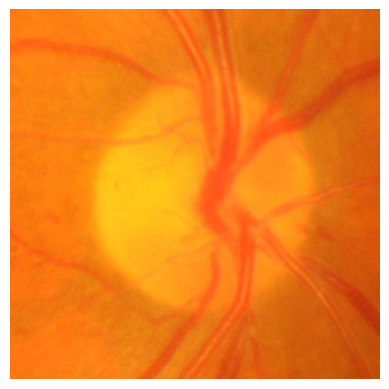

Step 2: Apply circular mask to the ROI


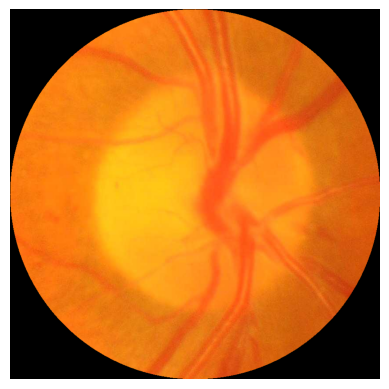

Step 3: The space color of the image is changed to HSV and the Value chanel (V) is extracted


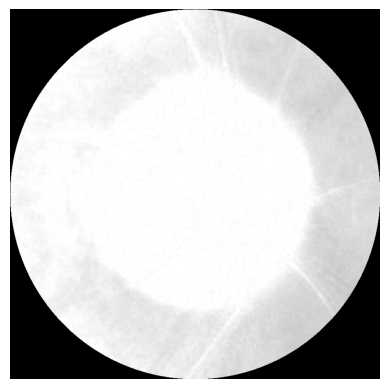

Step 4: Gamma correction with sigma = 100.0


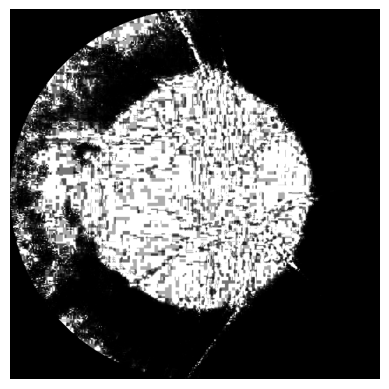

Step 5: Median blur with  kernel size = 51


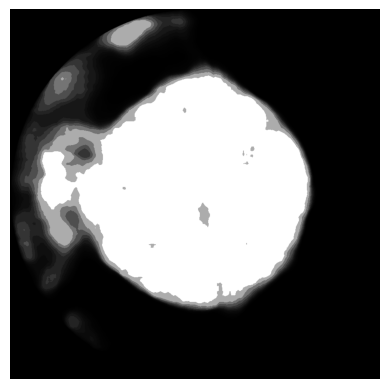

Step 6: Otsu threshold with th = 116.0


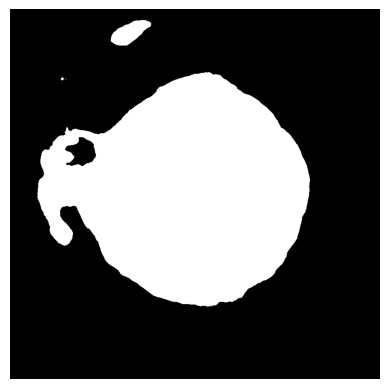

Step 7: Binary open with elliptical SE size = 55 x 55


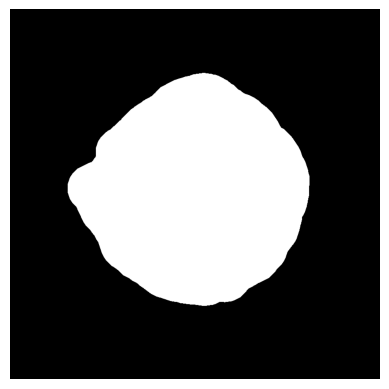

Step 8: Binary close with elliptical SE size = 55 x 55


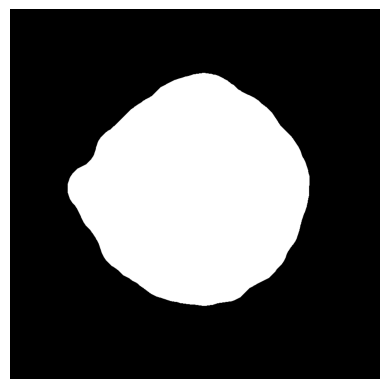

Step 9: OD bigest candidate


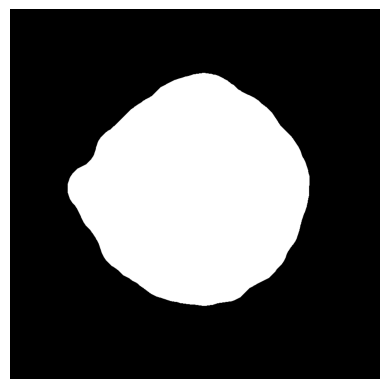

Advanced Removed OD and GT OD in green


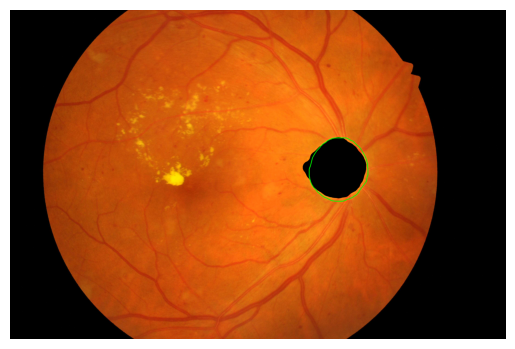

In [127]:
img_no_od_advanced = AdvancedODRemoval(notebook=True, explanation_depth=5).remove_od(img)

img_no_od_advanced_show = draw_mask(img_no_od_advanced.copy(), img_gt_od, mask_color=(0,255,0), thickness=5)
notebook_show(img_no_od_advanced_show, ("Advanced Removed OD and GT OD in green"), show=True, explanation_depth=1, step_depth=0)

## Soft Exudates detection

### Basic Soft exudates detection

In [128]:
class BasicSEDetection:

    CLAHE_CLIP = 14 
    BINARY_TH = 100
    BINARY_NEIGHBORS = 53
    MEAN_DIFFERENCE = 2
    OPEN_FACTOR = 3
    ROI_SEX_DILATE = 3

    GAUSSIAN_W=5
    SUB_P_GAMMA_C=0.3
    SUBD_WINDOW_SIZE = 35
    MIN_SIZE = 5

    def __init__(self, notebook=False, explanation_depth=0):
        self.notebook = notebook
        self.explanation_depth = explanation_depth

    def exudates_detection(self, img):
        
        od_enlargement_factor = 1.5
        img_no_od = BasicODRemoval().remove_od(img, circle_sf=od_enlargement_factor)
        notebook_show(img_no_od, ("Step 1: Remove OD region enlarged by a factor of", od_enlargement_factor), show=self.notebook, explanation_depth=self.explanation_depth, step_depth=1)

        img_resized, sf = get_image_10_percent(img_no_od)
        notebook_show(img_resized, ("Step 1.2: Reduce the image by a scale factor of ", sf), show=self.notebook, explanation_depth=self.explanation_depth, step_depth=3)


        img_preprocesed = self.__preprocessing(img_resized)
        
        img_reconstructed = self.__reconstruction(self.__subdivision(img_preprocesed))
        
        img_filtered_by_shape = self.__filter_shape(img_reconstructed)

        candidates, _ = cv.findContours(img_filtered_by_shape, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)

        # filtering small elements
        candidates = filter_contour_area(candidates, min_area=3)
        if self.notebook and self.explanation_depth >= 1: 
            img_notebook_1 = create_contours_mask(candidates, img_resized.shape)
            notebook_show(img_notebook_1, ("Step 14: Filter small elements with size <", 3), show=self.notebook, explanation_depth=self.explanation_depth, step_depth=1)

        # obtain bounding boxes
        rois = get_contours_rois(candidates, 
                        [(30, 0.7), (50, 0.6), (100, 0.4), (150, 0.3), (300, 0.2), (400, 0.1)],
                        img.shape)
        
        # resize contours to the original image
        resize_contours(candidates, 1/sf)
        rois = resize_rectangles(rois, 1/sf)

        return (candidates, rois)
    

    
    def __preprocessing(self, img):
        green = cv.extractChannel(img, 1)
        notebook_show(green, "Step 2: extract green channel", show=self.notebook, explanation_depth=self.explanation_depth, step_depth=1)

        clahe = cv.createCLAHE(clipLimit=self.CLAHE_CLIP)
        img_clahe = clahe.apply(green)
        notebook_show(img_clahe, ("Step 3: CLAHE with clip =", self.CLAHE_CLIP), show=self.notebook, explanation_depth=self.explanation_depth, step_depth=1)

        kernel_size = 3
        img_median_blur = cv.medianBlur(img_clahe, kernel_size)
        notebook_show(img_clahe, ("Step 4: Median blur with  kernel size =", kernel_size), show=self.notebook, explanation_depth=self.explanation_depth, step_depth=1)

        gamma_sigma = 0.5
        img_gamma_correction = gamma_correction(img_median_blur, gamma_sigma)
        notebook_show(img_gamma_correction, ("Step 5: Gamma correction with sigma =", 1/gamma_sigma), show=self.notebook, explanation_depth=self.explanation_depth, step_depth=1)

        return img_gamma_correction
    

    def __reconstruction(self, args):
        pieces, original_dimensions, self.SUBD_WINDOW_SIZE = args 
        img_rec = np.zeros((original_dimensions[0], original_dimensions[1]), np.uint8)
        for piece, patch_init in pieces:
            patch_size = (min(self.SUBD_WINDOW_SIZE, original_dimensions[0]-patch_init[0]),
                        min(self.SUBD_WINDOW_SIZE, original_dimensions[1]-patch_init[1]))
            img_rec[patch_init[0]: patch_init[0]+patch_size[0], patch_init[1]: patch_init[1]+patch_size[1]] = piece[:patch_size[0], :patch_size[1]]
        return img_rec


    def __subdivision(self, img):
        padding = (self.SUBD_WINDOW_SIZE-img.shape[0] % self.SUBD_WINDOW_SIZE, self.SUBD_WINDOW_SIZE-img.shape[1] % self.SUBD_WINDOW_SIZE)
        img_padding = cv.copyMakeBorder(img, 0, padding[0], 0, padding[1], cv.BORDER_CONSTANT, value=(0,0, 0))

        #-------------- added for the notebook
        if self.notebook and self.explanation_depth >=1:
            notebook_windows = []
            for y in range(0, img_padding.shape[0], self.SUBD_WINDOW_SIZE):
                for x in range(0, img_padding.shape[1], self.SUBD_WINDOW_SIZE):
                    notebook_windows.append((x, y, x+self.SUBD_WINDOW_SIZE, y+self.SUBD_WINDOW_SIZE))
            
            img_notebook_windows = draw_rois(img_padding, notebook_windows, thickness=1, color=(0,255,255))
            notebook_show(img_notebook_windows, ("Step 6: add padding =", padding, "to the image for then subdivide in tiles of =",self.SUBD_WINDOW_SIZE, "x", self.SUBD_WINDOW_SIZE), show=self.notebook, explanation_depth=self.explanation_depth, step_depth=1)
        
            sub_preprocessing_step_names = [["Gaussain blur with windows size of = ",self.GAUSSIAN_W, "x", self.GAUSSIAN_W],
                                            ["Gamma correction with sigma =", 1/self.SUB_P_GAMMA_C],
                                            ["Otsu threshold",] ]
            for sub_preprocessing_step in [0, 1, 2]:
                regions_notebook = []
                for y in range(0, img_padding.shape[0], self.SUBD_WINDOW_SIZE):
                    for x in range(0, img_padding.shape[1], self.SUBD_WINDOW_SIZE):
                        crop_img = img_padding[y:y+self.SUBD_WINDOW_SIZE, x:x+self.SUBD_WINDOW_SIZE]
                        if crop_img.mean() > 5:
                            crop_img_processed = self.__sub_preprocessing_notebook(crop_img, sub_preprocessing_step=sub_preprocessing_step)
                            regions_notebook.append((crop_img_processed, (y, x)))
                img_notebook_reconstructed = self.__reconstruction((regions_notebook, img.shape, self.SUBD_WINDOW_SIZE))
                
                img_notebook_reconstructed = cv.copyMakeBorder(img_notebook_reconstructed, 0, padding[0], 0, padding[1], cv.BORDER_CONSTANT, value=(0,0, 0))
                img_notebook_reconstructed = draw_rois(img_notebook_reconstructed, notebook_windows, thickness=1, color=(0,255,255))
                notebook_show(img_notebook_reconstructed, list(("Step", sub_preprocessing_step + 7, ":")) + sub_preprocessing_step_names[sub_preprocessing_step], show=self.notebook, explanation_depth=self.explanation_depth, step_depth=2)
        #-------------- end added for the notebook
            
        regions = []
        for y in range(0, img_padding.shape[0], self.SUBD_WINDOW_SIZE):
            for x in range(0, img_padding.shape[1], self.SUBD_WINDOW_SIZE):
                crop_img = img_padding[y:y+self.SUBD_WINDOW_SIZE, x:x+self.SUBD_WINDOW_SIZE]

                if crop_img.mean() > 5:
                    crop_img_processed = self.__sub_preprocessing(crop_img)
                    regions.append((crop_img_processed, (y, x)))
        return (regions, img.shape, self.SUBD_WINDOW_SIZE)
    

    def __sub_preprocessing(self, img):
        gaussian_w = self.GAUSSIAN_W
        if self.GAUSSIAN_W%2==0:
            gaussian_w+=1
        img_gaussian = cv.GaussianBlur(img, (gaussian_w, gaussian_w), 0)

        img_gamma = gamma_correction(img_gaussian, self.SUB_P_GAMMA_C)
        _, img_th = cv.threshold(img_gamma, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

        return img_th
    
    def __filter_shape(self, img):
        # breaking big elements
        img_big_elements_beaked = break_big_elements(img, size_th=300, se=5)
        notebook_show(img_big_elements_beaked, ("Step 10: Sequential filter for breaking big elements of size >", 300, "with Opening se =", 5), show=self.notebook, explanation_depth=self.explanation_depth, step_depth=3)

        img_big_elements_beaked = break_big_elements(img_big_elements_beaked, size_th=300, se=7)
        notebook_show(img_big_elements_beaked, ("Step 11: Sequential filter for breaking big elements of size >", 300, "with Opening se =", 7), show=self.notebook, explanation_depth=self.explanation_depth, step_depth=3)

        img_big_elements_beaked = break_big_elements(img_big_elements_beaked, size_th=400, se=10)
        notebook_show(img_big_elements_beaked, ("Step 12: Sequential filter for breaking big elements of size >", 400, "with Opening se =", 10), show=self.notebook, explanation_depth=self.explanation_depth, step_depth=3)

        # connecting small elements
        SE = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
        img_filtered_close = cv.morphologyEx(img_big_elements_beaked, cv.MORPH_CLOSE, SE)
        notebook_show(img_big_elements_beaked, ("Step 13: Connecting small elements with Closing se =", 3), show=self.notebook, explanation_depth=self.explanation_depth, step_depth=3)

        return img_filtered_close
    
    

    #-------------- added only to show the steps
    def __sub_preprocessing_notebook(self, img, sub_preprocessing_step=0):
        gaussian_w = self.GAUSSIAN_W
        if self.GAUSSIAN_W%2==0:
            gaussian_w+=1
        img_res = cv.GaussianBlur(img, (gaussian_w, gaussian_w), 0)

        if sub_preprocessing_step > 0:
            img_res = gamma_correction(img_res, self.SUB_P_GAMMA_C)

        if sub_preprocessing_step > 1:
            _, img_res = cv.threshold(img_res, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

        return img_res
    #-------------- end added only to show the steps


#### Example

Step 1: Remove OD region enlarged by a factor of 1.5


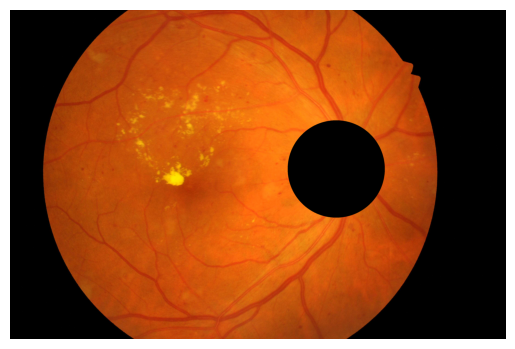

Step 1.2: Reduce the image by a scale factor of  0.1


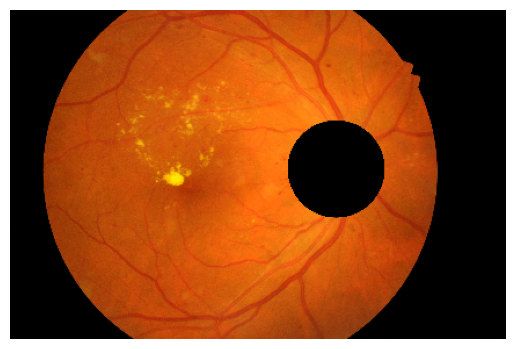

Step 2: extract green channel


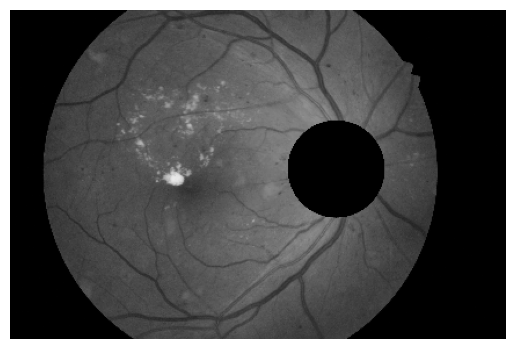

Step 3: CLAHE with clip = 14


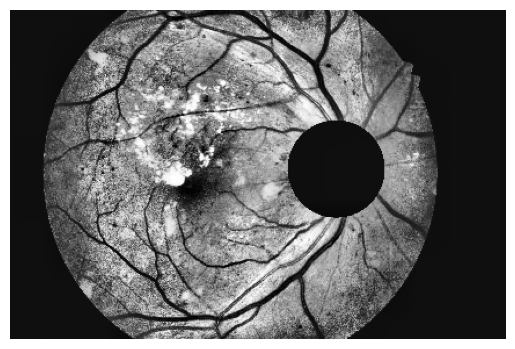

Step 4: Median blur with  kernel size = 3


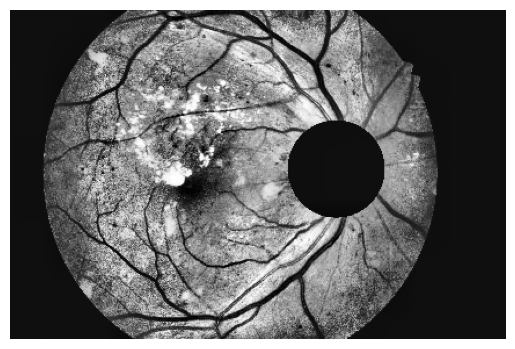

Step 5: Gamma correction with sigma = 2.0


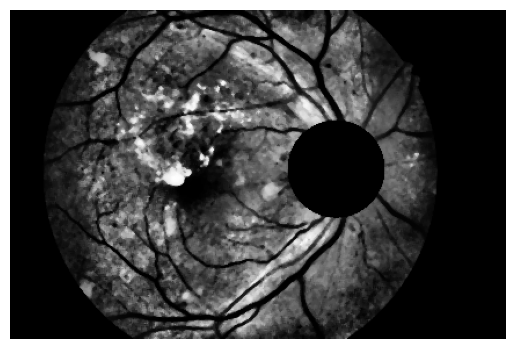

Step 6: add padding = (31, 27) to the image for then subdivide in tiles of = 35 x 35


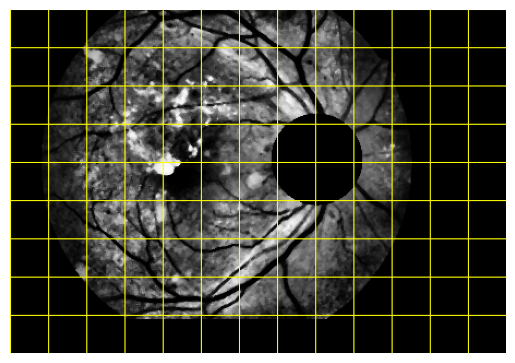

Step 7 : Gaussain blur with windows size of =  5 x 5


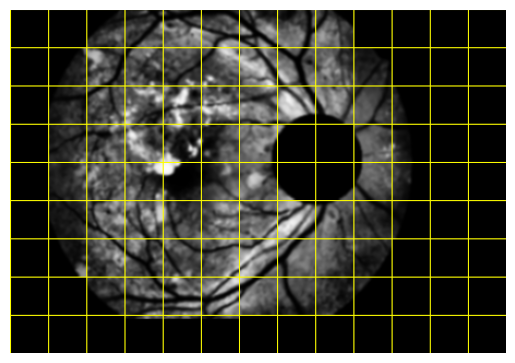

Step 8 : Gamma correction with sigma = 3.3333333333333335


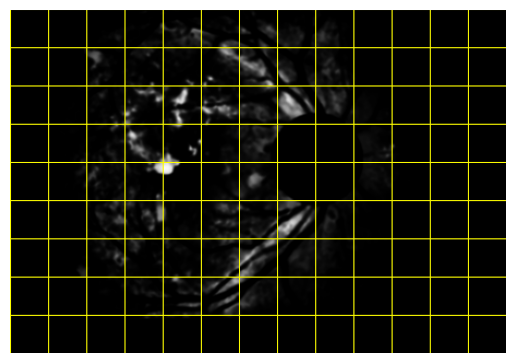

Step 9 : Otsu threshold


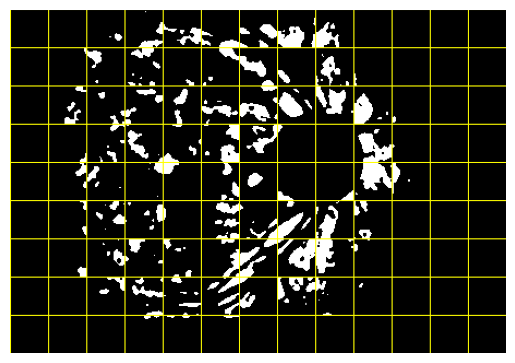

Step 10: Sequential filter for breaking big elements of size > 300 with Opening se = 5


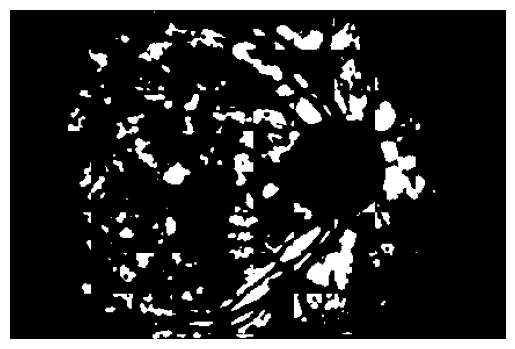

Step 11: Sequential filter for breaking big elements of size > 300 with Opening se = 7


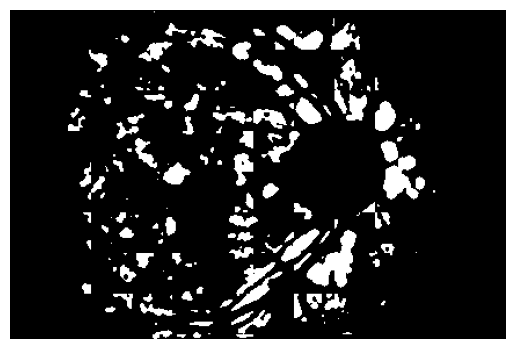

Step 12: Sequential filter for breaking big elements of size > 400 with Opening se = 10


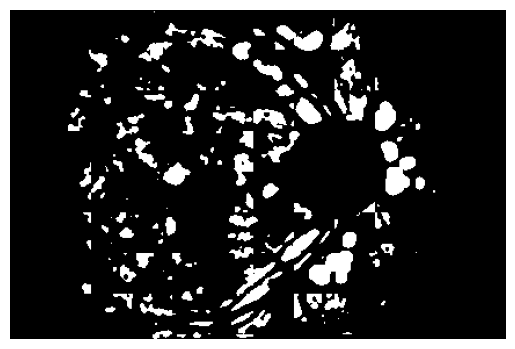

Step 13: Connecting small elements with Closing se = 3


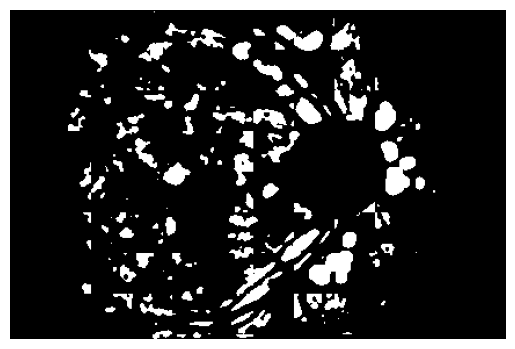

Step 14: Filter small elements with size < 3


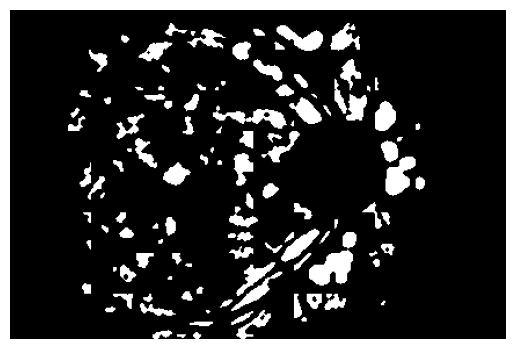

Removed OD and GT OD in green


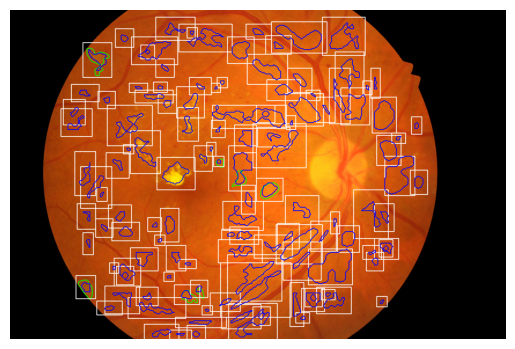

In [129]:
candidates, rois = BasicSEDetection(notebook=True, explanation_depth=5).exudates_detection(img)
img_se_basic_show = draw_mask(img.copy(), img_gt_se, mask_color=(0,255,0), thickness=5)

img_se_basic_show = draw_rois(img_se_basic_show, rois, thickness=5, color=(255, 255, 255))
img_se_basic_show = draw_contours(img_se_basic_show, candidates, thickness=5, color=(255,0,0))

notebook_show(img_se_basic_show, ("Removed OD and GT OD in green"), show=True, explanation_depth=1, step_depth=0)

### Advanced Soft exudates detection

In [130]:
class AdvancedSEDetection:

    COMPLETP_CLAHE_CLIP = 14
    COMPLETP_MEDIAN_BLUR_SIZE = 3
    COMPLETP_GAMMA = 0.5

    def __init__(self, notebook=False, explanation_depth=0):
        self.notebook = notebook
        self.explanation_depth = explanation_depth


    def exudates_detection(self, img):
        # basic detection
        basic_sex_candidates, basic_rois  = BasicSEDetection().exudates_detection(img)
        
        # od removal
        img_no_od = AdvancedODRemoval().remove_od(img)
        notebook_show(img_no_od, "Step 1: Remove OD", show=self.notebook, explanation_depth=self.explanation_depth, step_depth=1)


        # resize image and rois
        sf = 0.4
        img_no_od = resize(img_no_od, sf)
        basic_rois_resized = resize_rectangles(basic_rois, sf)
        # preprocess image
        img_no_od_pre = self.__complet_preprocessing(img_no_od)

        #-------------- added only to show the steps
        if self.notebook and self.explanation_depth >=1:
            self.__complet_preprocessing_notebook(img_no_od)
            img_notebook_rois = draw_rois(img_no_od_pre, basic_rois_resized, thickness=2, color=(0, 255, 255))
            notebook_show(img_notebook_rois, "Step 6: Work with each roi independently", show=self.notebook, explanation_depth=self.explanation_depth, step_depth=1)
        
            sub_preprocessing_step_names = [["Preprocessing the whole image depending on the ROI mean"],
                                            ["Median blur with windows size of =",15, "x", 15],
                                            ["Gamma correction with sigma =", 1/0.24],
                                            ["Otsu threshold",] ]
            for sub_preprocessing_step in [0, 1, 2, 3]:
                img_rois_advanced_preproced_notebook = []
                for roi in basic_rois_resized:
                    img_roi = img_no_od_pre[roi[1]:roi[3], roi[0]:roi[2]]

                    mean_intensity = img_roi.mean()
                    if mean_intensity <= 34:
                        clahe_gamma = 66
                    elif mean_intensity <= 130:
                        clahe_gamma= -0.4*mean_intensity + 90
                    else:
                        clahe_gamma = 35

                    img_no_od_pre = self.__complet_preprocessing(img_no_od, clahe_clip=clahe_gamma, gamma=clahe_gamma/100)
                    img_roi = img_no_od_pre[roi[1]:roi[3], roi[0]:roi[2]]
                    if sub_preprocessing_step == 0:
                        img_roi_processed = img_roi
                    else:
                        img_roi_processed =  self.__process_roi_notebook(img_roi, sub_preprocessing_step-1)
                    img_rois_advanced_preproced_notebook.append(img_roi_processed)

                # reconstruction original img
                img_notebook_reconstructed = self.__reconstruct(basic_rois_resized, img_rois_advanced_preproced_notebook, (int(img.shape[0]*sf), int(img.shape[1]*sf)))
                img_notebook_rois = draw_rois(img_notebook_reconstructed, basic_rois_resized, thickness=1, color=(0, 255, 255))
                notebook_show(img_notebook_rois, list(("Step", sub_preprocessing_step + 7, ":")) + sub_preprocessing_step_names[sub_preprocessing_step], show=self.notebook, explanation_depth=self.explanation_depth, step_depth=2)
        #-------------- end added only to show the steps


        img_rois_advanced_preproced = []
        # study rois
        for roi in basic_rois_resized:
            img_roi = img_no_od_pre[roi[1]:roi[3], roi[0]:roi[2]]

            # intensity modification
            mean_intensity = img_roi.mean()
            if mean_intensity <= 34:
                clahe_gamma = 66
            elif mean_intensity <= 130:
                clahe_gamma= -0.4*mean_intensity + 90
            else:
                clahe_gamma = 35

            img_no_od_pre = self.__complet_preprocessing(img_no_od, clahe_clip=clahe_gamma, gamma=clahe_gamma/100)
            img_roi = img_no_od_pre[roi[1]:roi[3], roi[0]:roi[2]]
            img_roi_processed =  self.__process_roi(img_roi)
            img_rois_advanced_preproced.append(img_roi_processed)

        # reconstruction original img
        img_reconstructed = self.__reconstruct(basic_rois_resized, img_rois_advanced_preproced, (int(img.shape[0]*sf), int(img.shape[1]*sf)))
        
        # fast dilate
        SE_dilate = cv.getStructuringElement(cv.MORPH_ELLIPSE, (7,7))
        img_reconstructed = cv.morphologyEx(img_reconstructed, cv.MORPH_DILATE, SE_dilate, iterations=1)
        notebook_show(img_reconstructed, ("Step 11: Global dilate with elliptical element of size", 7, "x", 7), show=self.notebook, explanation_depth=self.explanation_depth, step_depth=1)

        # find contours
        advance_sex_candidates, _ = cv.findContours(img_reconstructed, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        
        # dilate by contours
        advance_sex_candidates = self.__dilate_contours(advance_sex_candidates, img.shape, dilate=3) # Total sensibility: 0.73
        
        #-------------- added for the notebook
        if self.notebook and self.explanation_depth >= 1: 
            initial_contours_number = len(advance_sex_candidates)
            img_notebook_dilate_contours = draw_contours_with_random_colors(advance_sex_candidates, img_no_od_pre.shape)
            notebook_show(img_notebook_dilate_contours, ("Step 12: Individual dilate with elliptical element of size", 3, "x", 3), show=self.notebook, explanation_depth=self.explanation_depth, step_depth=1)
        #-------------- end added for the notebook

        # resize to the original size
        resize_contours(advance_sex_candidates, 1/sf)
        advance_sex_candidates = filter_contour_area(advance_sex_candidates, min_area=773*0.25, max_area=54468*1.5)
        
        #-------------- added for the notebook
        if self.notebook and self.explanation_depth >= 1: 
            img_notebook_filtered_elements = draw_contours_with_random_colors(advance_sex_candidates, img.shape)
            notebook_show(img_notebook_filtered_elements, ("Step 13: Filter contours by area >", 773*0.25, "and area <", 54468*1.5, "Removed contours =", initial_contours_number - len(advance_sex_candidates)), 
                        show=self.notebook, explanation_depth=self.explanation_depth, step_depth=1)
        #-------------- end added for the notebook

        # obtain rois
        advance_rois = get_contours_rois(advance_sex_candidates)
        return advance_sex_candidates, advance_rois




    def __process_roi(self, img_roi):
        img_out = cv.medianBlur(img_roi, 15) #57
        img_out = gamma_correction(img_out, 24/100) #24
        th, img_out = cv.threshold(img_out, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
        return img_out


    def __complet_preprocessing(self, img, clahe_clip=COMPLETP_CLAHE_CLIP, gamma=COMPLETP_GAMMA, median_blur=COMPLETP_MEDIAN_BLUR_SIZE):
        green = cv.extractChannel(img, 1) 
        clahe = cv.createCLAHE(clipLimit=clahe_clip) #14
        img_clahe = clahe.apply(green)
        img_median_blur = cv.medianBlur(img_clahe, median_blur) # 3
        img_gamma_correction = gamma_correction(img_median_blur, gamma) # 0.5
        return img_gamma_correction



    def __reconstruct(self, rois_coord, rois_imgs, img_shape):
        out = np.zeros((img_shape[0], img_shape[1]), np.uint8)
        for i in range(len(rois_imgs)):
            out_roi = out[rois_coord[i][1]:rois_coord[i][3], rois_coord[i][0]:rois_coord[i][2]]
            resultado = cv.bitwise_or(out_roi, rois_imgs[i])
            out[rois_coord[i][1]:rois_coord[i][3], rois_coord[i][0]:rois_coord[i][2]] = resultado

        return  out


    def __dilate_contours(self, advance_sex_candidates, img_shape, dilate=5):
        contour_len = len(advance_sex_candidates)
        for i in range(contour_len):
            mask_one = np.zeros((img_shape[0],img_shape[1]), np.uint8)
            cv.drawContours(mask_one, advance_sex_candidates, i, (255, 255, 255), -1)

            SE_dilate = cv.getStructuringElement(cv.MORPH_ELLIPSE, (dilate, dilate))
            mask_one = cv.morphologyEx(mask_one, cv.MORPH_DILATE, SE_dilate, iterations=1)
            
            contours, _ = cv.findContours(mask_one, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
            advance_sex_candidates = list(advance_sex_candidates)
            advance_sex_candidates[i] = contours[0]
            advance_sex_candidates = tuple(advance_sex_candidates)

        return advance_sex_candidates

    
    #-------------- added only to show the steps
    def __process_roi_notebook(self, img_roi, sub_preprocessing_step=0):
        img_out = cv.medianBlur(img_roi, 15) #57
        if sub_preprocessing_step > 0:
            img_out = gamma_correction(img_out, 24/100) #24
        if sub_preprocessing_step > 1:
            th, img_out = cv.threshold(img_out, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
        return img_out

    def __complet_preprocessing_notebook(self, img, clahe_clip = COMPLETP_CLAHE_CLIP, gamma = COMPLETP_GAMMA, median_blur = COMPLETP_MEDIAN_BLUR_SIZE, notebook=False, explanation_depth=0):
        green = cv.extractChannel(img, 1) 
        notebook_show(green, "Step 2: extract green channel", show=self.notebook, explanation_depth=self.explanation_depth, step_depth=1)

        clahe = cv.createCLAHE(clipLimit=clahe_clip) #14
        img_clahe = clahe.apply(green)
        notebook_show(img_clahe, ("Step 3: CLAHE with clip =", clahe_clip), show=self.notebook, explanation_depth=self.explanation_depth, step_depth=1)

        img_median_blur = cv.medianBlur(img_clahe, median_blur) # 3
        notebook_show(img_median_blur, ("Step 4: Median blur with  kernel size =", median_blur), show=self.notebook, explanation_depth=self.explanation_depth, step_depth=1)

        img_gamma_correction = gamma_correction(img_median_blur, gamma) # 0.5
        notebook_show(img_gamma_correction, ("Step 5: Gamma correction with sigma =", 1/gamma), show=self.notebook, explanation_depth=self.explanation_depth, step_depth=1)

        return img_gamma_correction
    #-------------- end added only to show the steps


#### Example

Step 1: Remove OD


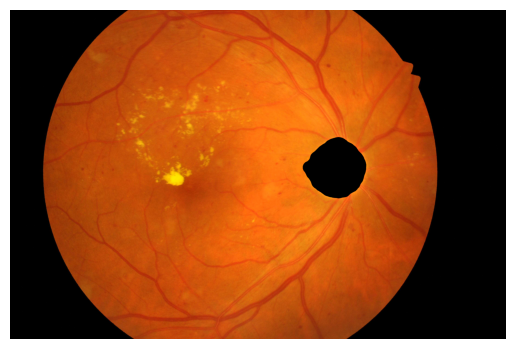

Step 2: extract green channel


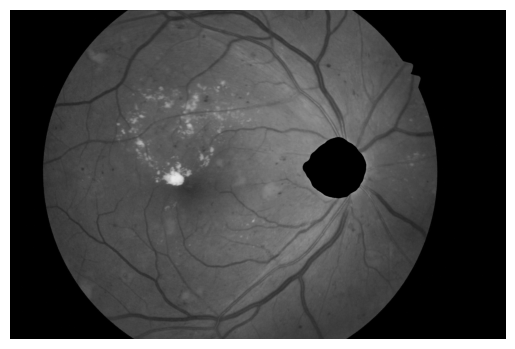

Step 3: CLAHE with clip = 14


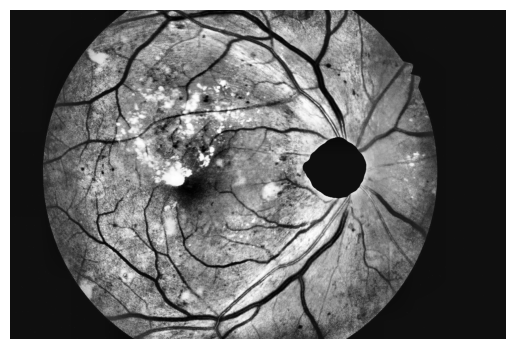

Step 4: Median blur with  kernel size = 3


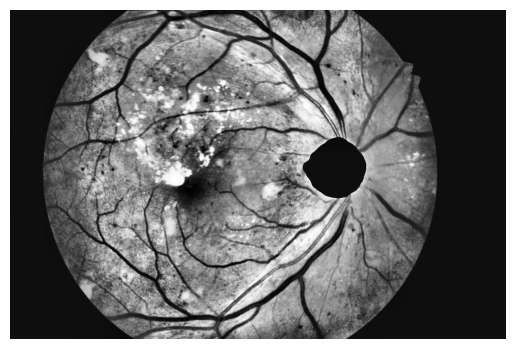

Step 5: Gamma correction with sigma = 2.0


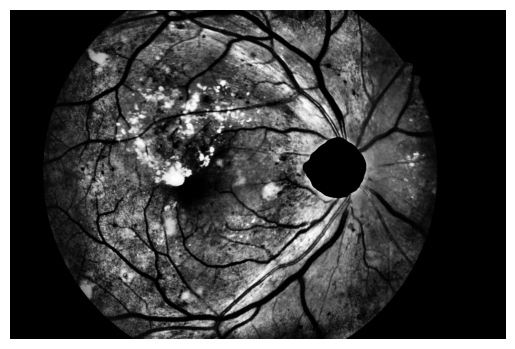

Step 6: Work with each roi independently


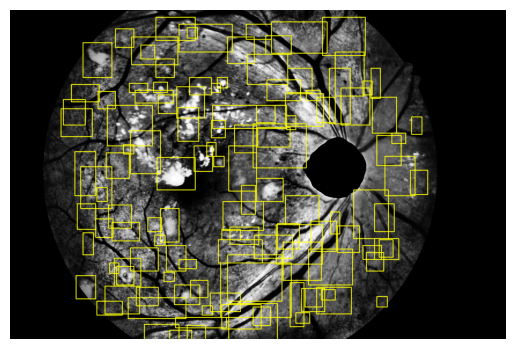

Step 7 : Preprocessing the whole image depending on the ROI mean


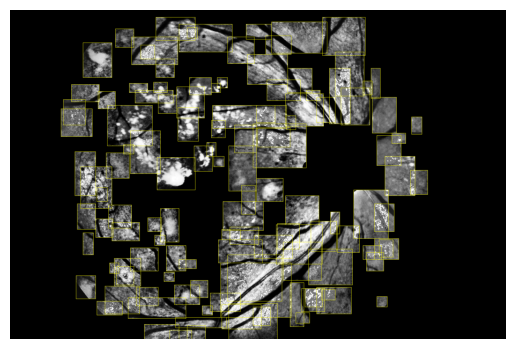

Step 8 : Median blur with windows size of = 15 x 15


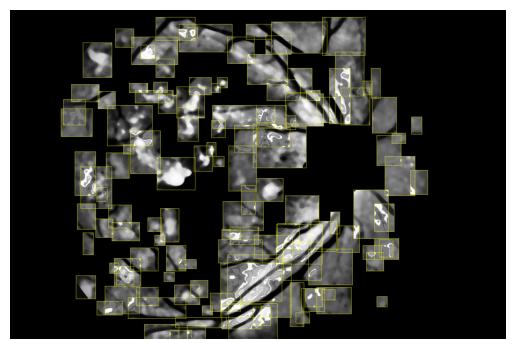

Step 9 : Gamma correction with sigma = 4.166666666666667


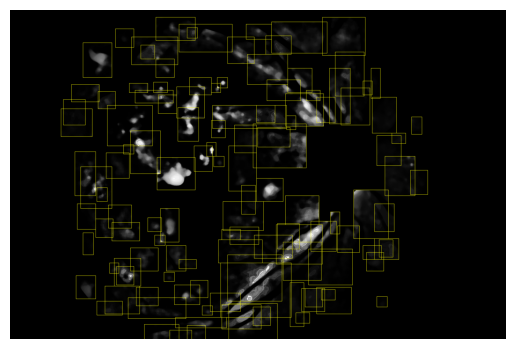

Step 10 : Otsu threshold


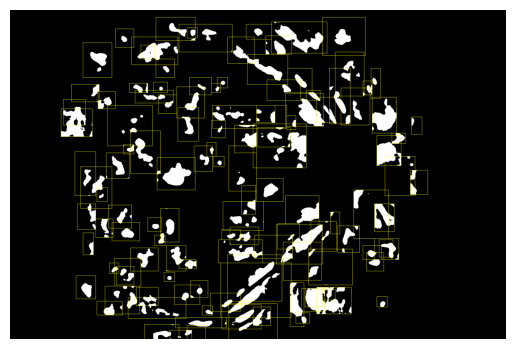

Step 11: Global dilate with elliptical element of size 7 x 7


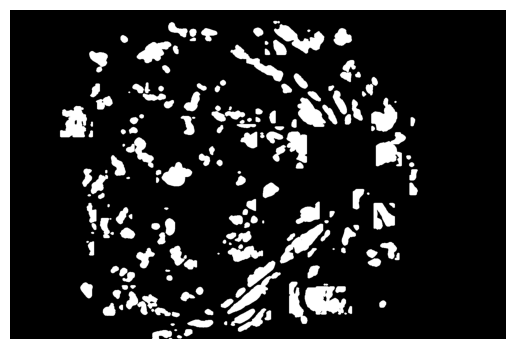

Step 12: Individual dilate with elliptical element of size 3 x 3


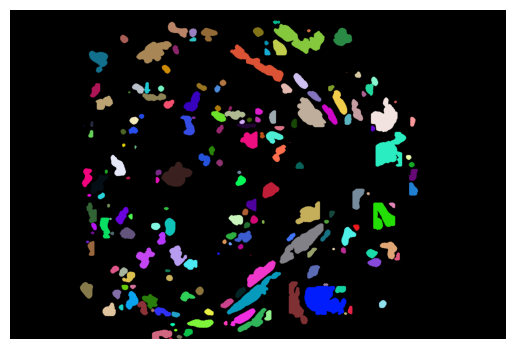

Step 13: Filter contours by area > 193.25 and area < 81702.0 Removed contours = 4


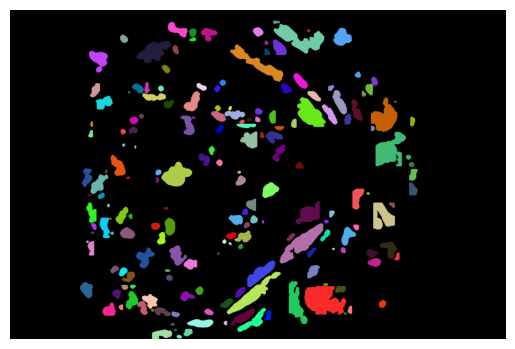

Advanced exudates detection


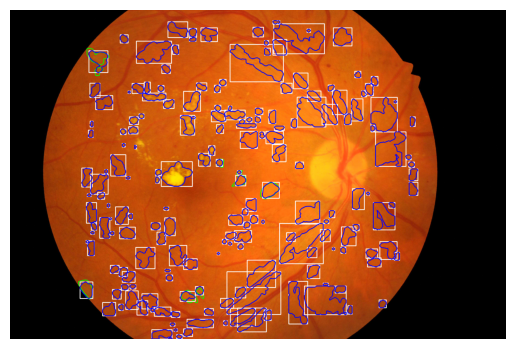

In [131]:
candidates, rois = AdvancedSEDetection(notebook=True, explanation_depth=5).exudates_detection(img)
img_se_advanced_show = draw_mask(img.copy(), img_gt_se, mask_color=(0,255,0), thickness=5)

img_se_advanced_show = draw_rois(img_se_advanced_show, rois, thickness=5, color=(255, 255, 255))
img_se_advanced_show = draw_contours(img_se_advanced_show, candidates, thickness=5, color=(255,0,0))

notebook_show(img_se_advanced_show, ("Advanced exudates detection"), show=True, explanation_depth=1, step_depth=0)

## Features Extraction

In [132]:
class SEFeaturesExtractor:

    def extact_features(self, img, contours, rois, roi_enhancement='none'):
        features_list = []

        for i in tqdm(range(len(rois))):
            mask = create_contours_mask(contours, img.shape, i)
            mask_roi = get_roi(mask, rois[i])

            img_roi = get_roi(img, rois[i])
            img_roi_masked = apply_mask(img_roi, mask_roi, -1)

            features = self.extract_features_from_roi(img_roi_masked, roi_enhancement)
            features_list.append(features)
        return features_list


    def extract_features_from_roi(self, img_roi_masked, roi_enhancement):
        img_enhanced = self.enhance_image(img_roi_masked, roi_enhancement) 

        roi_fourier = self.calculate_fourier_descriptors(img_enhanced) # 7 0-6
        roi_shape = self.calculate_shape_descriptors(img_enhanced) # 6 7-12
        roi_hu = self.calculate_hu_moments(img_enhanced) # 7 13-19
        roi2glcm = self.extract_glcm_features(img_enhanced) #37 20-56
        roi2lbp = self.extract_lbp_features(img_enhanced) #10 57-66 (255 57-311)
        roi_color = self.calculate_color_descriptors(img_roi_masked) # 21 67-87 (255 312-332)
        roi_glrlm = self.extract_features_glrlm(img_enhanced) # 5 88-92 (255 333-333)

        all_features = np.concatenate((roi_fourier, roi_shape, roi_hu, roi2glcm, roi2lbp, roi_color, roi_glrlm))

        return all_features


    def extract_features_glrlm(self, roi):
        app = glrlm.GLRLM()
        glrlm_feat = app.get_features(roi, 8)

        return glrlm_feat.Features

    def calculate_haralick_features(self, glcm):
        # Calculate Haralick texture features from GLCM
        haralick_features = skimage.feature.graycoprops(glcm)

        # Compute the mean of each Haralick feature
        haralick_mean = np.mean(haralick_features, axis=0)

        return haralick_mean

    def calculate_cluster_prominence(self, glcm):
        p = np.indices(glcm.shape)[0]
        q = np.indices(glcm.shape)[1]

        mean_row = np.sum(p * glcm) / np.sum(glcm)
        mean_col = np.sum(q * glcm) / np.sum(glcm)

        cluster_prominence = np.sum(((p + q - mean_row - mean_col) ** 4) * glcm) / np.sum(glcm) ** 2
        return cluster_prominence

    def calculate_cluster_shade(self, glcm):
        # Calculate cluster shade
        p = np.indices(glcm.shape)[0]
        q = np.indices(glcm.shape)[1]
        mean_row = np.sum(p * glcm) / np.sum(glcm)
        mean_col = np.sum(q * glcm) / np.sum(glcm)
        cluster_shade = np.sum(((p + q - mean_row - mean_col) ** 3) * glcm) / np.sum(glcm) ** 2
        return cluster_shade

    def calculate_max_probability(self, glcm):
        # Calculate max probability
        max_probability = np.max(glcm) / np.sum(glcm)
        return max_probability

    def calculate_sum_average(self, glcm):
        # Calculate sum average
        p = np.indices(glcm.shape)[0]
        q = np.indices(glcm.shape)[1]
        sum_average = np.sum((p + q) * glcm) / np.sum(glcm)
        return sum_average

    def calculate_sum_variance(self, glcm):
        # Calculate sum variance
        p = np.indices(glcm.shape)[0]
        q = np.indices(glcm.shape)[1]
        sum_average = self.calculate_sum_average(glcm)
        sum_variance = np.sum(((p + q) - sum_average) ** 2 * glcm) / np.sum(glcm)
        return sum_variance

    def calculate_sum_entropy(self, glcm):
        # Calculate sum entropy
        glcm_normalized = glcm / np.sum(glcm)
        sum_entropy = -np.sum(glcm_normalized * np.log2(glcm_normalized + 1e-10))
        return sum_entropy

    def calculate_difference_variance(self, glcm):
        # Calculate difference variance
        p = np.indices(glcm.shape)[0]
        q = np.indices(glcm.shape)[1]
        difference_variance = np.sum(((p - q) ** 2) * glcm) / np.sum(glcm)
        return difference_variance

    def calculate_difference_entropy(self, glcm):
        # Calculate difference entropy
        glcm_normalized = glcm / np.sum(glcm)
        difference_entropy = -np.sum(glcm_normalized * np.log2(glcm_normalized + 1e-10))
        return difference_entropy

    def extract_glcm_features(self, roi):
        graycom = skimage.feature.graycomatrix(roi, distances=[1], angles=[0, np.pi / 4, np.pi / 2, 3 * np.pi / 4], levels=256)

        contrast = skimage.feature.graycoprops(graycom, 'contrast')
        dissimilarity = skimage.feature.graycoprops(graycom, 'dissimilarity')
        homogeneity = skimage.feature.graycoprops(graycom, 'homogeneity')
        energy = skimage.feature.graycoprops(graycom, 'energy')
        correlation = skimage.feature.graycoprops(graycom, 'correlation')
        asm = skimage.feature.graycoprops(graycom, 'ASM')

        cluster_prominence = self.calculate_cluster_prominence(graycom)
        cluster_shade = self.calculate_cluster_shade(graycom)
        max_probability = self.calculate_max_probability(graycom)
        sum_average = self.calculate_sum_average(graycom)
        sum_variance = self.calculate_sum_variance(graycom)
        sum_entropy = self.calculate_sum_entropy(graycom)
        difference_variance = self.calculate_difference_variance(graycom)
        difference_entropy = self.calculate_difference_entropy(graycom)
        haralick = self.calculate_haralick_features(graycom)

        lacunarity = 1 - (contrast.var() / contrast.mean() ** 2)
        # print(contrast.shape)

        features = np.concatenate([
            contrast.ravel(),
            dissimilarity.ravel(),
            homogeneity.ravel(),
            energy.ravel(),
            correlation.ravel(),
            asm.ravel(),
            lacunarity.ravel(),
            cluster_prominence.ravel(),
            cluster_shade.ravel(),
            max_probability.ravel(),
            sum_average.ravel(),
            sum_variance.ravel(),
            sum_entropy.ravel(),
            difference_variance.ravel(),
            difference_entropy.ravel(),
            haralick.ravel()
        ])

        return features


    def extract_lbp_features(self, roi):
        lbp = skimage.feature.local_binary_pattern(roi, 8, 1, method='uniform')
        num_patterns = int(lbp.max() + 1)  

        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, num_patterns + 1), range=(0, num_patterns), density=True)
        return hist

    def calculate_fourier_descriptors(self, img):
        f = np.fft.fft2(img)

        fshift = np.fft.fftshift(f)

        magnitude_spectrum = np.abs(fshift)
        magnitude_spectrum /= np.sum(magnitude_spectrum) 

        phase_spectrum = np.angle(fshift)
        phase_spectrum /= (2 * np.pi)  

        total_energy = np.sum(magnitude_spectrum**2)

        cumulative_energy = np.cumsum(magnitude_spectrum**2) / total_energy

        mean_amplitude = np.mean(magnitude_spectrum)
        std_amplitude = np.std(magnitude_spectrum)
        max_amplitude = np.max(magnitude_spectrum)
        mean_phase = np.mean(phase_spectrum)
        std_phase = np.std(phase_spectrum)
        max_phase = np.max(phase_spectrum)
        energy_ratio = cumulative_energy[10] 

        return np.array([mean_amplitude, std_amplitude, max_amplitude, mean_phase, std_phase, max_phase, energy_ratio])

    def calculate_shape_descriptors(self, img):
        _, th = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
        contours, _ = cv.findContours(th, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
        num_regions, _, _, _ = cv.connectedComponentsWithStats(th)
        sodality = num_regions - 1

        for contour in contours:
            area = cv.contourArea(contour)
            perimeter = cv.arcLength(contour, True)

            if perimeter == 0:
                circularity = 0
            else:
                circularity = (4 * np.pi * area) / (perimeter**2)

            _, _, w, h = cv.boundingRect(contour)
            aspect_ratio = float(w) / h

            rect_area = w * h    
            extent = area / rect_area


        return np.array([area, perimeter, circularity, aspect_ratio, sodality, extent])


    def calculate_hu_moments(self, img):
        image_array = np.array(img, dtype=np.float32)

        covariance_matrix = np.cov(image_array, rowvar=False)

        # Calcular los momentos centrales
        moments = cv.moments(covariance_matrix)

        # Calcular los momentos de Hu
        hu_moments = cv.HuMoments(moments)

        return np.array([hu_moments[0][0], hu_moments[1][0], hu_moments[2][0], hu_moments[3][0], hu_moments[4][0], hu_moments[5][0], hu_moments[6][0]])


    def calculate_color_descriptors(self, img):
        img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
        img_lab = cv.cvtColor(img, cv.COLOR_RGB2LAB)
        img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
        intensity_values = img_gray.flatten()


        red_channel = cv.extractChannel(img, 0)
        green_channel = cv.extractChannel(img, 1)
        blue_channel = cv.extractChannel(img, 2)

        std_red = np.std(red_channel)
        std_green = np.std(green_channel)
        std_blue = np.std(blue_channel)
        mean_red = np.mean(red_channel)
        mean_green = np.mean(green_channel)
        mean_blue = np.mean(blue_channel)

        h_channel = cv.extractChannel(img_hsv, 0)
        s_channel = cv.extractChannel(img_hsv, 1)
        v_channel = cv.extractChannel(img_hsv, 2)

        std_h = np.std(h_channel)
        std_s = np.std(s_channel)
        std_v = np.std(v_channel)
        mean_h = np.mean(h_channel)
        mean_s = np.mean(s_channel)
        mean_v = np.mean(v_channel)

        l_channel = cv.extractChannel(img_lab, 0)
        a_channel = cv.extractChannel(img_lab, 1)
        b_channel = cv.extractChannel(img_lab, 2)

        std_l = np.std(l_channel)
        std_a = np.std(a_channel)
        std_b = np.std(b_channel)
        mean_l = np.mean(l_channel)
        mean_a = np.mean(a_channel)
        mean_b = np.mean(b_channel)

        variance = np.var(img_gray)

        skewness = scipy.stats.skew(intensity_values)
        kurt = scipy.stats.kurtosis(intensity_values)


        return np.array([std_red, std_green, std_blue, std_h, std_s, std_v, std_l, std_a, std_b,
                        mean_red, mean_green, mean_blue, mean_h, mean_s, mean_v, mean_l, mean_a, mean_b, variance, skewness, kurt])


    def enhance_image(self, img, roi_enhancement):
        if roi_enhancement == 'none':
            img_enhanced = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
        else:
            green = cv.extractChannel(img, 1) 

            if roi_enhancement == 'green':
                img_enhanced = green
                
            elif roi_enhancement == 'median_blur':
                img_enhanced = cv.medianBlur(green, 3)  

            elif roi_enhancement == 'clahe':
                clahe = cv.createCLAHE(clipLimit=14)
                img_enhanced = clahe.apply(green)

            elif roi_enhancement == 'gamma':
                img_enhanced = gamma_correction(green, 0.8)

            elif roi_enhancement == 'equalize':
                img_enhanced = cv.equalizeHist(green)

            elif roi_enhancement == 'gaussian_blur':
                img_enhanced = cv.GaussianBlur(green, (3, 3), 0)

            elif roi_enhancement == 'normalize':
                img_enhanced = cv.normalize(green, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)

            elif roi_enhancement == 'denoising':
                img_enhanced = cv.fastNlMeansDenoising(green, h=10, searchWindowSize=21)

        return img_enhanced




#### Example

In [147]:
contours, rois = AdvancedSEDetection().exudates_detection(img)
features_list = SEFeaturesExtractor().extact_features(img, contours, rois)
# print(features_list)
print(len(features_list))

100%|██████████| 171/171 [00:27<00:00,  6.31it/s]

171


## Feature Engeneering

In [134]:


class SEFeaturesEngeneering:

    def __init__(self):
        self.scaler = None
        self.selector = None
        self.zero_columns = None

    def fit_transform(self, features, labels, nb_features):

        # step 1: satndarize features
        self.scaler = StandardScaler()
        feat_standarized = self.scaler.fit_transform(features)

        # step 2: remove null colums
        self.zero_columns = np.all(feat_standarized == 0, axis=0)
        feat_standarized = feat_standarized[:, ~self.zero_columns]

        # step 3: feature selection
        if nb_features > 0:
            self.selector = SelectKBest(f_classif, k=nb_features)
            feat_standarized = self.selector.fit_transform(feat_standarized, labels)

        return feat_standarized


    def transform(self, features):
        feat_standarized = self.scaler.transform(features)
        feat_standarized = feat_standarized[:, ~self.zero_columns]
        if self.selector is not None:
            feat_standarized = self.selector.transform(feat_standarized)

        return feat_standarized


#### Example

In [135]:
# # Obtain the features
# contours, rois = AdvancedSEDetection().exudates_detection(img)
# print('Extracting features')
# features_list = SEFeaturesExtractor().extact_features(img, contours, rois)
# features = np.array(features_list)

# # Obtain the labels
# print('Labeling contours')
# gt_contours, _  = cv.findContours(img_gt_se, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
# contours_labels, img_sensitivity = label_contours(contours, gt_contours, img.shape, overlap_threshold=0.5)

# # Feature engeneering
# print('Feature engeneering')
# nb_features = -1
# fe = SEFeaturesEngeneering()
# best_features = fe.fit_transform(features, contours_labels, nb_features)

# print('features shape', features.shape)
# print('best features shape', best_features.shape)
# plot_points_2D(features[:, 0:2], contours_labels)
# plot_points_2D(best_features[:, 0:2], contours_labels)

## Training and Validation

In [136]:
# ---- Training data
TRAIN_IMGS_FOLDER = 'data/images/training'
TRAIN_GTS_FOLDER = 'data/groundtruths/groundtruths_SE/training'
TRAIN_IMGS_TEMPLATE_NAME = 'IDRiD_{:02d}.jpg'
TRAIN_GTS_TEMPLATE_NAME = 'IDRiD_{:02d}_SE.tif'
TRAIN_FEATURES_PATH_NAME = './feat.csv'
TRAIN_IMGS_NUMBERS = range(1, 55)

# ---- Validation data
VAL_IMGS_FOLDER = 'data/images/test'
VAL_GTS_FOLDER = 'data/groundtruths/groundtruths_SE/test'
VAL_IMGS_TEMPLATE_NAME = 'IDRiD_{:02d}.jpg'
VAL_GTS_TEMPLATE_NAME = 'IDRiD_{:02d}_SE.tif'
VAL_FEATURES_PATH_NAME = './feat_val.csv'
VAL_IMGS_NUMBERS = range(55, 76)


# ---- Overlap TH
OVERLAP_TH = 0.3

# ---- model path name
MODEL_PATH_NAME = './svc_model.pkl'


In [137]:
class SEDetection:

    def __init__(self):
        self.feat_engeneering = SEFeaturesEngeneering()
        self.svm = SVC(kernel="poly", gamma='auto', class_weight='balanced', probability=True)
        self.trained = False
        self.nb_features = -1

    def train(self, nb_features=-1, features_path_name=None):
        print('-------- Train mode --------')

        self.nb_features = nb_features
        self.imgs_numbers = TRAIN_IMGS_NUMBERS
        self.imgs_folder = TRAIN_IMGS_FOLDER
        self.imgs_template_name = TRAIN_IMGS_TEMPLATE_NAME
        self.gts_folder = TRAIN_GTS_FOLDER
        self.gts_template_name = TRAIN_GTS_TEMPLATE_NAME

        # extract features
        if features_path_name is None:
            self.__extract_training_eval_fetures()
            self.feature_path_name = TRAIN_FEATURES_PATH_NAME
        else:
            print('Using provided features')
            self.feature_path_name = features_path_name
        # feature engeneering
        loaded_features = pd.read_csv(self.feature_path_name)
        x = loaded_features.iloc[:, 2:].values
        y = loaded_features.iloc[:, 1].values
        
        x = self.feat_engeneering.fit_transform(x, y, self.nb_features)

        # train model
        self.svm.fit(x, y)
        pred_y = self.svm.predict(x)
        prob_y = self.svm.predict_proba(x)

        self.trained = True
        return y, pred_y, prob_y


    def eval(self, features_path_name=None):
        print('-------- Evaluation mode --------')
        if not self.trained:
            raise Exception('Model not trained')
        
        self.imgs_numbers = VAL_IMGS_NUMBERS
        self.imgs_folder = VAL_IMGS_FOLDER
        self.imgs_template_name = VAL_IMGS_TEMPLATE_NAME
        self.gts_folder = VAL_GTS_FOLDER
        self.gts_template_name = VAL_GTS_TEMPLATE_NAME
        self.feature_path_name = VAL_FEATURES_PATH_NAME

        # extract features
        if features_path_name is None:
            self.__extract_training_eval_fetures()
            self.feature_path_name = TRAIN_FEATURES_PATH_NAME
        else:
            print('Using provided features')
            self.feature_path_name = features_path_name
            
        # feature engeneering
        loaded_features = pd.read_csv(self.feature_path_name)
        x = loaded_features.iloc[:, 2:].values
        y = loaded_features.iloc[:, 1].values
        
        x = self.feat_engeneering.transform(x)

        # train model
        pred_y = self.svm.predict(x)
        prob_y = self.svm.predict_proba(x)

        return y, pred_y, prob_y


    def test(self, img):
        print('-------- Test mode --------')

        # if not self.trained:
        #     raise Exception('Model not trained')
        
        candidate_contours, rois = AdvancedSEDetection().exudates_detection(img)
        x =  SEFeaturesExtractor().extact_features(img, candidate_contours, rois)
        x = self.feat_engeneering.transform(x)

        pred_y = self.svm.predict(x)
        prob_y = self.svm.predict_proba(x)

        return pred_y, prob_y, candidate_contours, rois
        

    def __extract_training_eval_fetures(self):
        all_fetures = []
        for img_id in self.imgs_numbers:
            print('---- Processing image', img_id, '----')
            path_img = os.path.join(self.imgs_folder, self.imgs_template_name.format(img_id))
            path_gt = os.path.join(self.gts_folder, self.gts_template_name.format(img_id))
            
            img = cv.imread(path_img, cv.IMREAD_COLOR)
            img_gt = load_gt(path_gt, img.shape)

            candidate_contours, rois = AdvancedSEDetection().exudates_detection(img)
            gt_contours, _  = cv.findContours(img_gt, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)

            print('Labeling contours')
            candidates_labels, img_sensitivity = label_contours(candidate_contours, gt_contours, img.shape, overlap_threshold=OVERLAP_TH)
            print('Extracting features')
            features_list = SEFeaturesExtractor().extact_features(img, candidate_contours, rois, roi_enhancement='none')
            print('sensitivity:', img_sensitivity)
            np_feat = np.array(features_list)
            np_feat = np.column_stack(([img_id]*len(candidates_labels), candidates_labels, np_feat))
            all_fetures.append(np_feat)

        all_fetures = np.concatenate(all_fetures)
        pandas_df = pd.DataFrame(all_fetures)
        pandas_df.to_csv(self.feature_path_name, index=False)


#### Example

In [138]:
# se_detector = SEDetection()
# train_y, train_pred_y, train_prob_y = se_detector.train()
# val_y, val_pred_y, val_prob_y = se_detector.eval()



## Evaluation Metrics

In [139]:

class EvaluationMetrics:

    def compute_metrics(self, y, y_pred, y_prob, print_results=False):
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred, pos_label=1, zero_division=0)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        mcc = matthews_corrcoef(y, y_pred)  
        auprc = average_precision_score(y, y_prob[:,1], average='weighted')
        balanced_accuracy = balanced_accuracy_score(y, y_pred)

        metrics_dict = {'accuracy': accuracy,
                        'precision': precision,
                        'recall': recall,
                        'f1': f1,
                        'mcc': mcc,
                        'auprc': auprc,
                        'balanced_accuracy': balanced_accuracy}
        if print_results:
                for key, value in metrics_dict.items():
                    print("{}: {:.2f}".format(key, value))

        return metrics_dict

    def plot_roc_curve(self, y, y_prob):
        fpr, tpr, _ = roc_curve(y, y_prob[:,1])
        roc_auc = auc(fpr, tpr)

        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()


    def plot_presition_recall(self, X, y, svm):
        display = PrecisionRecallDisplay.from_estimator(svm, X, y, name="results")
        _ = display.ax_.set_title("2-class Precision-Recall curve")


#### Example

-------- Train mode --------
Using provided features
-------- Evaluation mode --------
Using provided features
Train metrics
accuracy: 0.92
precision: 0.10
recall: 0.92
f1: 0.18
mcc: 0.29
auprc: 0.40
balanced_accuracy: 0.92


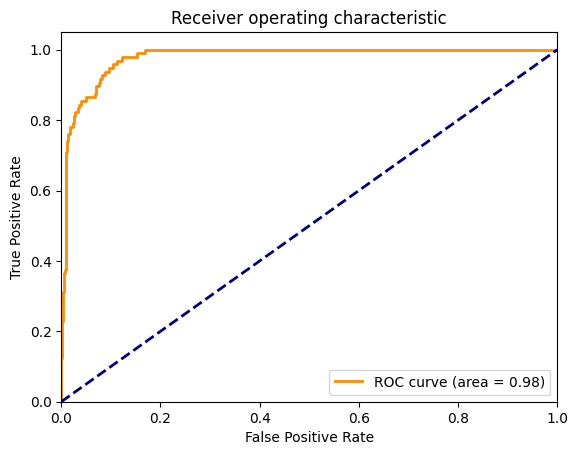


Validation metrics
accuracy: 0.94
precision: 0.09
recall: 0.73
f1: 0.17
mcc: 0.25
auprc: 0.19
balanced_accuracy: 0.83


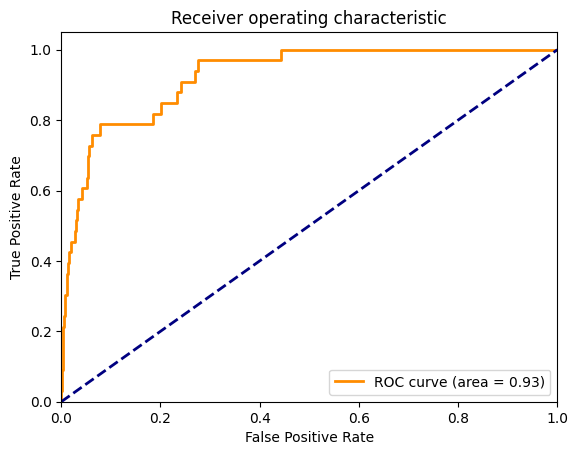

In [140]:
se_detector = SEDetection()
train_y, train_pred_y, train_prob_y = se_detector.train(features_path_name='./feat_training_complete.csv')
val_y, val_pred_y, val_prob_y = se_detector.eval(features_path_name='./feat_val_complete.csv')

# ---- Train Metrics
print('Train metrics')
train_metrics = EvaluationMetrics().compute_metrics(train_y, train_pred_y, train_prob_y, print_results=True)
EvaluationMetrics().plot_roc_curve(train_y, train_prob_y)

# ---- Val Metrics
print('\nValidation metrics')
val_metrics = EvaluationMetrics().compute_metrics(val_y, val_pred_y, val_prob_y, print_results=True)
EvaluationMetrics().plot_roc_curve(val_y, val_prob_y)

# Test with your images!

IMPORTANT: The results of this code are not validated by specialists, and it is only part of a university project.

#### Train the model with the obtained features

In [141]:
se_detector = SEDetection()
train_y, train_pred_y, train_prob_y = se_detector.train(features_path_name='./feat_training_complete.csv')


-------- Train mode --------
Using provided features


#### Load your fundus image

In [144]:
img = cv.imread('data/images/training/IDRiD_01.jpg', cv.IMREAD_COLOR)

# ---- if no gorund truth available set to None
# img_gt_se = None
# img_gt_od = None
img_gt_se = cv.imread('data/groundtruths/groundtruths_SE/training/IDRiD_01_SE.tif', cv.IMREAD_GRAYSCALE)
img_gt_od = cv.imread('data/groundtruths/groundtruths_OD/training/IDRiD_01_OD.tif', cv.IMREAD_GRAYSCALE)


#### Make your prediction

In [145]:
pred_y, prob_y, candidate_contours, rois = se_detector.test(img)
filtered_contours = [contour for i, contour in enumerate(candidate_contours) if pred_y[i] == 1]

-------- Test mode --------


100%|██████████| 171/171 [00:26<00:00,  6.43it/s]


#### Visualize the results

Result for image:  data/images/training/IDRiD_13.jpg ; bleu: detected SE, white: candidates SE , green: real SE , magenta: segmented OD, black: real OD


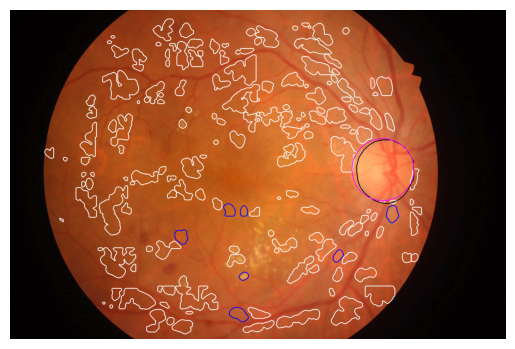

Number of SE detected before SVM: 171
Number of SE detected exudates: 7


In [146]:
img_show = img.copy()
img_show = draw_mask(img_show, img_gt_se, mask_color=(0,255,0), thickness=5)
img_show =  draw_contours(img_show, candidate_contours, thickness=5, color=(255,255,255))
img_show = draw_contours(img_show, filtered_contours, thickness=5, color=(255,0,0))

# also show the OD mask
img_show = draw_mask(img_show, img_gt_od, mask_color=(0,0,0), thickness=5)
mask_od_advanced = AdvancedODRemoval().get_od_mask(img)
img_show = draw_mask(img_show, mask_od_advanced, mask_color=(255,0,255), thickness=5)

notebook_show(img_show, ("Result for image: ", img_path_name, "; bleu: detected SE, white: candidates SE , green: real SE , magenta: segmented OD, black: real OD"), show=True, explanation_depth=1, step_depth=0)
print('Number of SE detected before SVM:', len(candidate_contours))
print('Number of SE detected exudates:', len(filtered_contours))

